Columns: ['OBJECTID', 'DEPTO', 'COD_DEP', 'MPIO', 'COD_MUN', 'CANTON', 'COD_CAN', 'COD_ZON_CE', 'COD_SEC_CE', 'COD_SEG_CE', 'AREA_ID', 'SEG_ID', 'AREA_KM2', 'SHAPE_Leng', 'Shape_Le_1', 'Shape_Area', 'geometry']


,OBJECTID,DEPTO,COD_DEP,MPIO,COD_MUN,CANTON,COD_CAN,COD_ZON_CE,COD_SEC_CE,COD_SEG_CE,AREA_ID,SEG_ID,AREA_KM2,SHAPE_Leng,Shape_Le_1,Shape_Area,geometry
0,1,AHUACHAPAN,01,ATIQUIZAYA,03,AREA URBANA,00,00,002,1015,U,01031015,0.04352,1261.063244,1261.021707,4.352687e+04,"POLYGON ((418812.952 316576.975, 418746.765 31..."
1,2,AHUACHAPAN,01,GUAYMANGO,06,EL ESCALON,04,00,005,0016,R,01060016,1.65778,8536.170387,8535.889017,1.657675e+06,"POLYGON ((410461.711 290699.337, 410465.964 29..."
2,3,AHUACHAPAN,01,AHUACHAPAN,01,AREA URBANA,00,01,003,1015,U,01011015,0.07500,1165.975037,1165.936550,7.499598e+04,"POLYGON ((408803.942 310868.046, 408827.573 31..."
3,4,AHUACHAPAN,01,AHUACHAPAN,01,AREA URBANA,00,01,003,1014,U,01011014,0.05010,988.854292,988.821600,5.010403e+04,"POLYGON ((408703.804 310887.996, 408677.276 31..."
4,5,AHUACHAPAN,01,AHUACHAPAN,01,AREA URBANA,00,02,009,1019,U,01011019,0.06910,1135.758238,1135.720871,6.910402e+04,"POLYGON ((408404.439 311600.8, 408456.541 3115..."



--- OBJECTID ---
Unique values (12435): [ 1  2  3  4  5  6  7  8  9 10] ...

--- DEPTO ---
Unique values (14): ['AHUACHAPAN' 'LA LIBERTAD' 'CHALATENANGO' 'LA PAZ' 'LA UNION'
 'SAN SALVADOR' 'SAN MIGUEL' 'CABAÑAS' 'CUSCATLAN' 'MORAZAN'] ...

--- COD_DEP ---
Unique values (14): ['01' '05' '04' '08' '14' '06' '12' '09' '07' '13'] ...

--- MPIO ---
Unique values (256): ['ATIQUIZAYA' 'GUAYMANGO' 'AHUACHAPAN' 'SAN FRANCISCO MENENDEZ'
 'CONCEPCION DE ATACO' 'APANECA' 'JUJUTLA' 'TACUBA' 'SAN LORENZO'
 'EL REFUGIO'] ...

--- COD_MUN ---
Unique values (33): ['03' '06' '01' '08' '04' '02' '07' '11' '09' '05'] ...

--- CANTON ---
Unique values (1327): ['AREA URBANA' 'EL ESCALON' 'EL ZAPOTE' 'EL IZCAQUILIO' 'EL SACRAMENTO'
 'SANTA ROSA ACACALCO' 'LLANO DE DOÑA MARIA' 'PALO PIQUE' 'EL JUNQUILLO'
 'SALITRERO'] ...

--- COD_CAN ---
Unique values (42): ['00' '04' '05' '03' '27' '20' '22' '07' '09' '18'] ...

--- COD_ZON_CE ---
Unique values (15): ['00' '01' '02' '03' '04' '05' '13' '09' '08' '07'] ...

<Axes: >

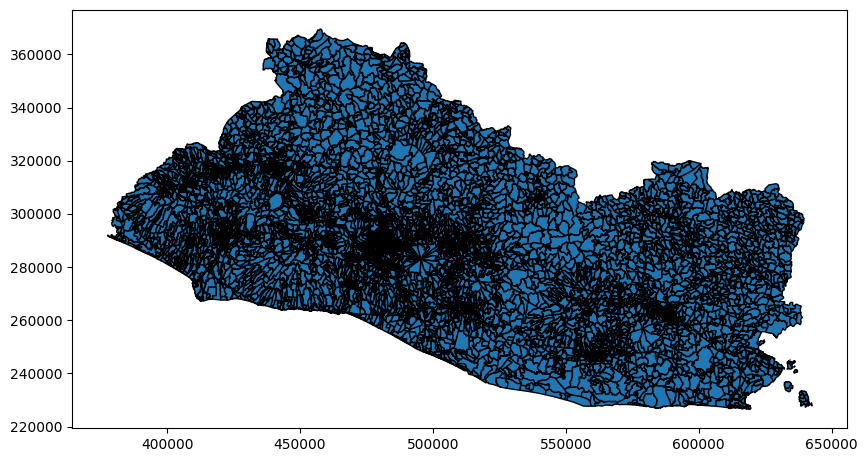

In [6]:
import geopandas as gpd

# Load the admin boundaries shapefile
ADMIN_SHP = "../data/segmentos_censales/DIGESTYC_Segmentos2007.shp"
admin_gdf = gpd.read_file(ADMIN_SHP)

# Show all columns
print("Columns:", admin_gdf.columns.tolist())

# Show the first few rows
display(admin_gdf.head())

# Show unique values of each column (for categorical IDs or names)
for col in admin_gdf.columns:
    print(f"\n--- {col} ---")
    try:
        unique_vals = admin_gdf[col].unique()
        print(f"Unique values ({len(unique_vals)}):", unique_vals[:10], "..." if len(unique_vals) > 10 else "")
    except Exception as e:
        print("Could not get unique values:", e)

# Optionally: Plot the boundaries to visually inspect
admin_gdf.plot(edgecolor='k', figsize=(10, 10))


# Extracting Raster Values

In [12]:
import geopandas as gpd
from rasterstats import zonal_stats
import rasterio

# Load your data
ADMIN_SHP = "../data/segmentos_censales/DIGESTYC_Segmentos2007.shp"
POP_RASTER = "../data/population_slv_2018-10-01/population_slv_2018-10-01.tif"

admin_gdf = gpd.read_file(ADMIN_SHP)

# Ensure CRS matches raster
with rasterio.open(POP_RASTER) as src:
    raster_crs = src.crs
if admin_gdf.crs != raster_crs:
    admin_gdf = admin_gdf.to_crs(raster_crs)

# Compute zonal statistics (sum of population per polygon)
stats = zonal_stats(
    admin_gdf,
    POP_RASTER,
    stats=["sum"],
    nodata=-9999,  # Change if your raster's nodata value is different!
    geojson_out=False,
    all_touched=False,  # If True, counts every pixel touched by polygon; else only those whose center is inside
    raster_out=False
)

# Add the population sum to the GeoDataFrame
admin_gdf["population_sum"] = [s["sum"] for s in stats]

# Preview: show total, min, max, and a sample
print("Total extracted population:", admin_gdf["population_sum"].sum())
print("Min:", admin_gdf["population_sum"].min(), "Max:", admin_gdf["population_sum"].max())
admin_gdf[["SEG_ID", "DEPTO", "MPIO", "CANTON", "population_sum"]].head()


Total extracted population: 6122528.491389058
Min: 4.983195658785813 Max: 10514.767136485238


,SEG_ID,DEPTO,MPIO,CANTON,population_sum
0,01031015,AHUACHAPAN,ATIQUIZAYA,AREA URBANA,238.455255
1,01060016,AHUACHAPAN,GUAYMANGO,EL ESCALON,264.954844
2,01011015,AHUACHAPAN,AHUACHAPAN,AREA URBANA,428.328838
3,01011014,AHUACHAPAN,AHUACHAPAN,AREA URBANA,386.335814
4,01011019,AHUACHAPAN,AHUACHAPAN,AREA URBANA,545.909303


# Add more stats

In [13]:
import geopandas as gpd
from rasterstats import zonal_stats
import rasterio

ADMIN_SHP = "../data/segmentos_censales/DIGESTYC_Segmentos2007.shp"
POP_RASTER = "../data/population_slv_2018-10-01/population_slv_2018-10-01.tif"

admin_gdf = gpd.read_file(ADMIN_SHP)

# Ensure CRS matches raster
with rasterio.open(POP_RASTER) as src:
    raster_crs = src.crs
if admin_gdf.crs != raster_crs:
    admin_gdf = admin_gdf.to_crs(raster_crs)

# Choose statistics
stat_list = ["count", "min", "mean", "max", "median", "sum"]

# Compute stats
stats = zonal_stats(
    admin_gdf,
    POP_RASTER,
    stats=stat_list,
    nodata=-9999,   # adjust if your raster nodata is different
    geojson_out=False,
    all_touched=False
)

# Attach to gdf with pop_ prefix
for stat in stat_list:
    admin_gdf[f"pop_{stat}"] = [s[stat] for s in stats]

# Check columns and a sample
print(admin_gdf[[col for col in admin_gdf.columns if col.startswith("pop_")]].head())


   pop_count   pop_min  pop_mean   pop_max  pop_median     pop_sum
0         25  9.538210  9.538210  9.538210    9.538210  238.455255
1         30  8.831828  8.831828  8.831828    8.831828  264.954844
2         51  8.398605  8.398605  8.398605    8.398605  428.328838
3         46  8.398605  8.398605  8.398605    8.398605  386.335814
4         65  8.398605  8.398605  8.398605    8.398605  545.909303


In [16]:
cols = ["SEG_ID", "DEPTO", "MPIO", "CANTON"] + [col for col in admin_gdf.columns if col.startswith("pop_")]
admin_gdf[cols]

,SEG_ID,DEPTO,MPIO,CANTON,pop_count,pop_min,pop_mean,pop_max,pop_median,pop_sum
0,01031015,AHUACHAPAN,ATIQUIZAYA,AREA URBANA,25,9.538210,9.538210,9.538210,9.538210,238.455255
1,01060016,AHUACHAPAN,GUAYMANGO,EL ESCALON,30,8.831828,8.831828,8.831828,8.831828,264.954844
2,01011015,AHUACHAPAN,AHUACHAPAN,AREA URBANA,51,8.398605,8.398605,8.398605,8.398605,428.328838
3,01011014,AHUACHAPAN,AHUACHAPAN,AREA URBANA,46,8.398605,8.398605,8.398605,8.398605,386.335814
4,01011019,AHUACHAPAN,AHUACHAPAN,AREA URBANA,65,8.398605,8.398605,8.398605,8.398605,545.909303
...,...,...,...,...,...,...,...,...,...,...
12430,11091006,USULUTAN,JUCUAPA,AREA URBANA,76,9.509106,9.509106,9.509106,9.509106,722.692077
12431,11090010,USULUTAN,JUCUAPA,EL CHAGUITE,48,7.345905,9.148573,9.509106,9.509106,439.131493
12432,11020005,USULUTAN,BERLIN,SAN JOSE,61,6.732712,6.732712,6.732712,6.732712,410.695457
12433,14080044,LA UNION,LA UNION,ISLA ZACATILLO,85,3.372684,3.372684,3.372684,3.372684,286.678169


In [20]:
(admin_gdf.pop_mean == admin_gdf.pop_min).sum()

np.int64(7323)

In [17]:
admin_gdf.groupby("MPIO")["pop_sum"].sum().sort_values(ascending=False).head(10)


MPIO
SANTA ANA         260899.542270
SAN SALVADOR      258945.158114
SAN MIGUEL        228439.728643
SOYAPANGO         219963.379487
CIUDAD DELGADO    182029.636101
TONACATEPEQUE     167560.678886
APOPA             139990.063234
MEJICANOS         134215.706158
SANTA TECLA       123828.100495
AHUACHAPAN        123301.989318
Name: pop_sum, dtype: float64